In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
train = "/kaggle/input/indoor-object-detection/train"
valid = "/kaggle/input/indoor-object-detection/valid"
test  = "/kaggle/input/indoor-object-detection/test"


In [2]:
%pip -q install ultralytics supervision
from ultralytics import checks
checks()


Ultralytics 8.3.183 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6411.4/8062.4 GB disk)


In [3]:
import os, glob, yaml

ROOT = "/kaggle/input/indoor-object-detection"
OUT_YAML = "/kaggle/working/indoor.yaml"

# 1) Try to find an existing YAML inside the dataset
candidates = [p for p in glob.glob(f"{ROOT}/**/*.yaml", recursive=True)
              if os.path.basename(p).lower() in ("data.yaml", "dataset.yaml", "indoor.yaml")]
data = None

if candidates:
    with open(candidates[0], "r") as f:
        data = yaml.safe_load(f)

# 2) If not found, build one
if not data:
    # Try to read classes from a text file, else infer from labels
    names_file = os.path.join(ROOT, "classes.txt")
    if os.path.exists(names_file):
        with open(names_file, "r") as f:
            names = [ln.strip() for ln in f if ln.strip()]
        nc = len(names)
    else:
        # Infer nc from label files (IDs only; names will be class_0..class_{nc-1})
        label_files = glob.glob(f"{ROOT}/**/*.txt", recursive=True)
        ids = set()
        for lf in label_files:
            try:
                with open(lf, "r") as f:
                    for line in f:
                        if line.strip():
                            ids.add(int(line.split()[0]))
            except:
                pass
        nc = (max(ids) + 1) if ids else 1
        names = [f"class_{i}" for i in range(nc)]

    data = {
        "train": f"{ROOT}/train/images",
        "val":   f"{ROOT}/valid/images",
        "test":  f"{ROOT}/test/images",
        "nc":    nc,
        "names": names,
    }
else:
    # 3) Rewrite paths for this Kaggle dataset layout
    data["train"] = f"{ROOT}/train/images"
    data["val"]   = f"{ROOT}/valid/images"
    data["test"]  = f"{ROOT}/test/images"

# 4) Save the final YAML
os.makedirs(os.path.dirname(OUT_YAML), exist_ok=True)
with open(OUT_YAML, "w") as f:
    yaml.safe_dump(data, f, sort_keys=False)

print("Saved YAML to:", OUT_YAML)
print(data)


Saved YAML to: /kaggle/working/indoor.yaml
{'train': '/kaggle/input/indoor-object-detection/train/images', 'val': '/kaggle/input/indoor-object-detection/valid/images', 'test': '/kaggle/input/indoor-object-detection/test/images', 'nc': 10, 'names': ['door', 'cabinetDoor', 'refrigeratorDoor', 'window', 'chair', 'table', 'cabinet', 'couch', 'openedDoor', 'pole']}


In [4]:
# Ultralytics supports CLI or Python API. Use CLI to match your example.
!yolo task=detect mode=train model=yolo11s.pt data=/kaggle/working/indoor.yaml epochs=10 imgsz=640 plots=True


Ultralytics 8.3.183 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/indoor.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=

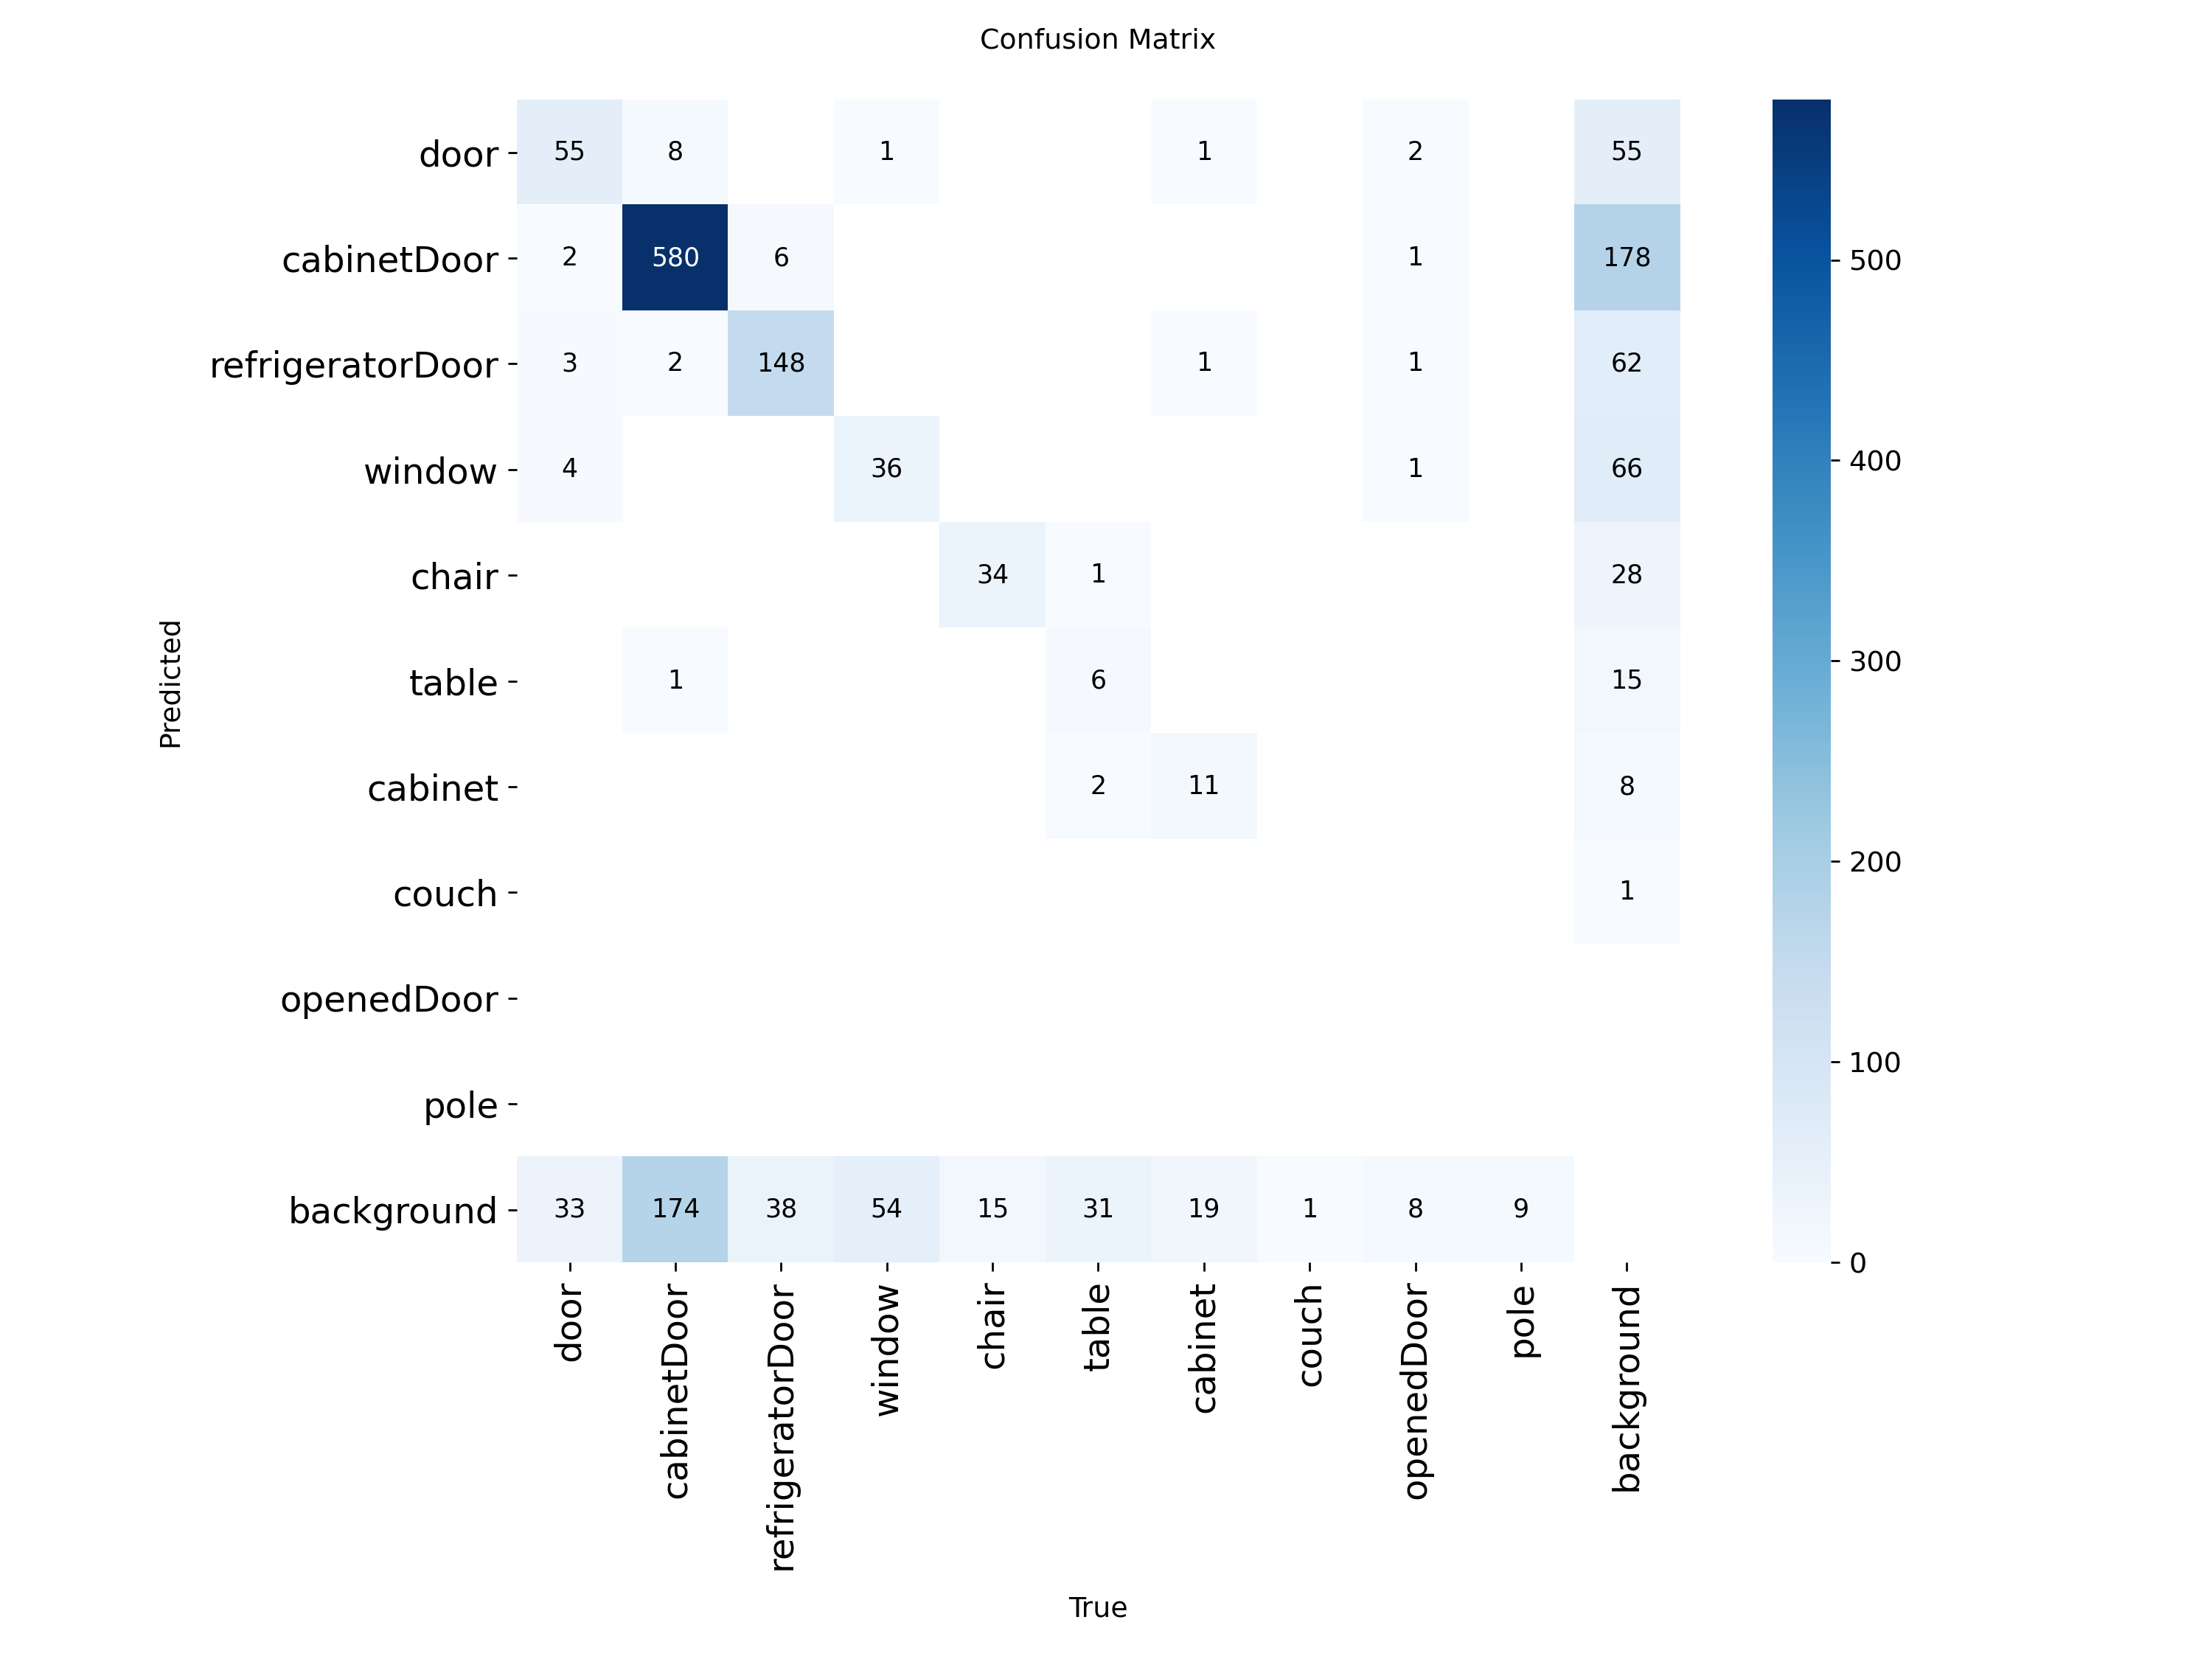

In [6]:
from IPython.display import Image as IPyImage, display

cm_path = "/kaggle/working/runs/detect/train/confusion_matrix.png"
if os.path.exists(cm_path):
    display(IPyImage(filename=cm_path, width=700))
else:
    print("confusion_matrix.png not found (training may not have finished or plots were disabled).")


Ultralytics 8.3.183 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,416,670 parameters, 0 gradients, 21.3 GFLOPs

image 1/107 /kaggle/input/indoor-object-detection/test/images/1003.png: 480x640 3 doors, 51.4ms
image 2/107 /kaggle/input/indoor-object-detection/test/images/1014.png: 480x640 1 window, 12.5ms
image 3/107 /kaggle/input/indoor-object-detection/test/images/1015.png: 480x640 1 door, 12.4ms
image 4/107 /kaggle/input/indoor-object-detection/test/images/1020.png: 480x640 (no detections), 12.4ms
image 5/107 /kaggle/input/indoor-object-detection/test/images/1021.png: 480x640 (no detections), 12.4ms
image 6/107 /kaggle/input/indoor-object-detection/test/images/1023.png: 480x640 2 windows, 2 chairs, 12.4ms
image 7/107 /kaggle/input/indoor-object-detection/test/images/1026.png: 480x640 1 door, 2 windows, 1 chair, 2 couchs, 12.4ms
image 8/107 /kaggle/input/indoor-object-detection/test/images/1027.png: 480x640 1 chair, 12.4ms
image 9

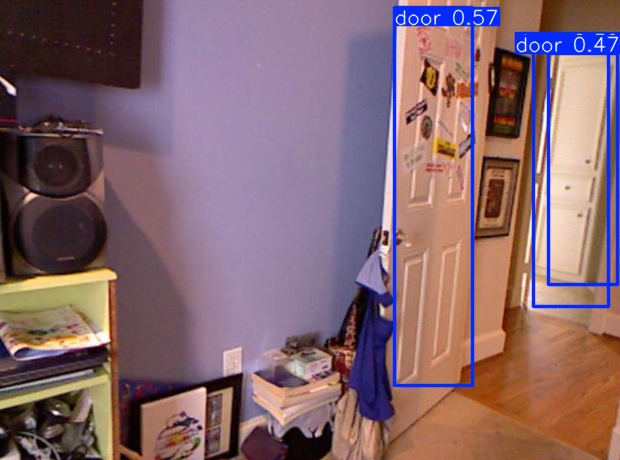

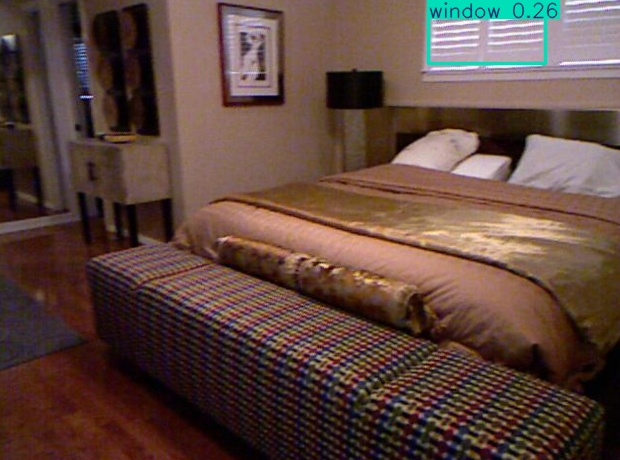

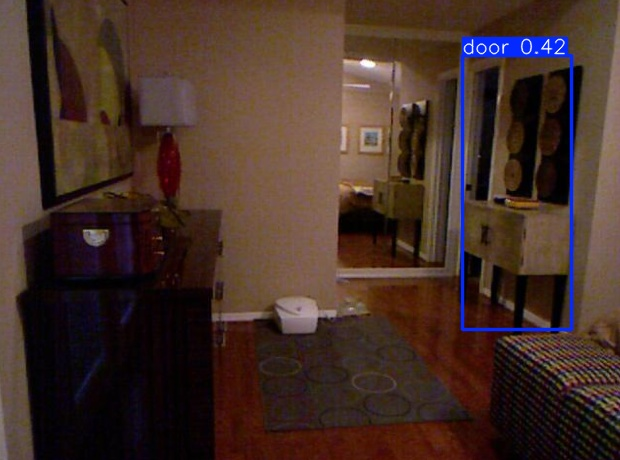

In [5]:
# Predict on test set and save results
!yolo task=detect mode=predict model=/kaggle/working/runs/detect/train/weights/best.pt conf=0.25 source=/kaggle/input/indoor-object-detection/test/images save=True

# Show a few predicted images
import glob, os
from IPython.display import Image as IPyImage, display

pred_dir_candidates = sorted(glob.glob("/kaggle/working/runs/detect/predict*"), key=os.path.getmtime)
if pred_dir_candidates:
    latest = pred_dir_candidates[-1]
    imgs = sorted(glob.glob(os.path.join(latest, "*.jpg")))[:3]
    for p in imgs:
        display(IPyImage(filename=p, width=700))
        print()
else:
    print("No predict folder found.")



Target layer: Conv


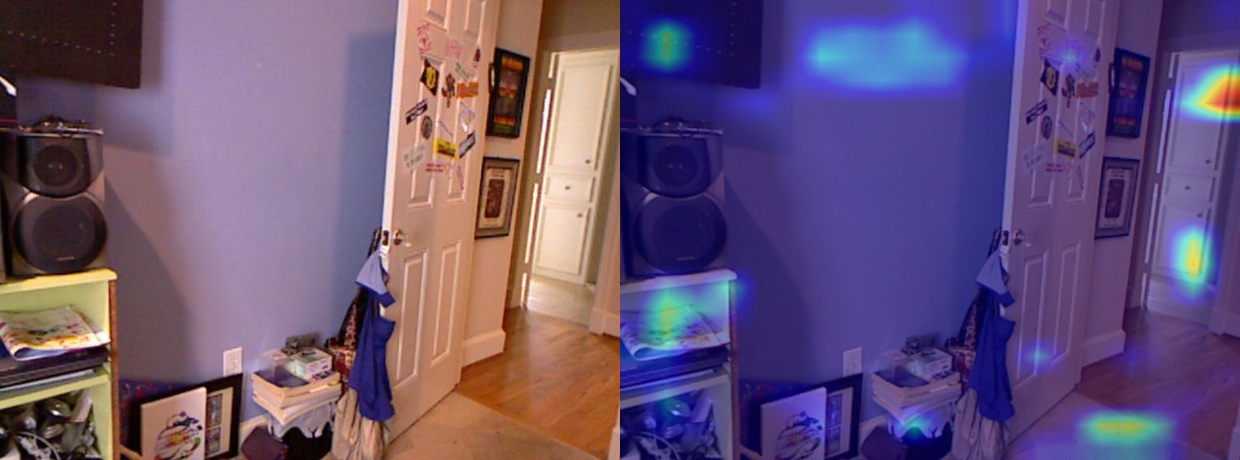

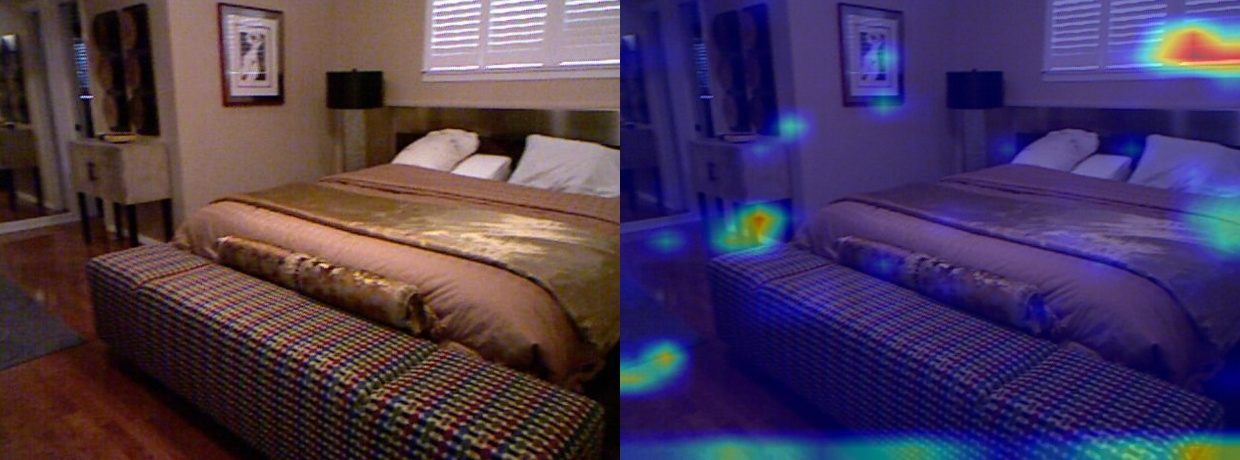

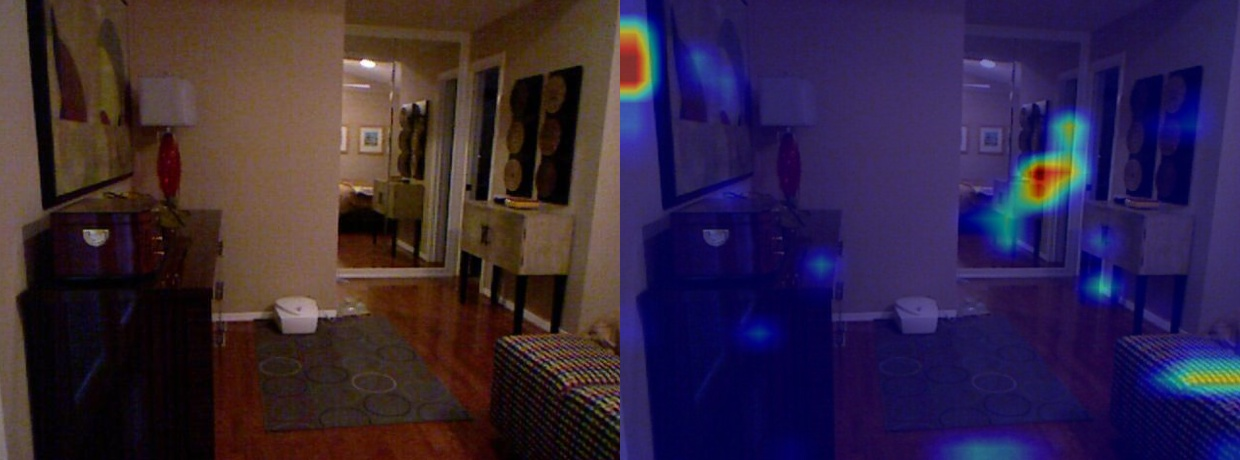

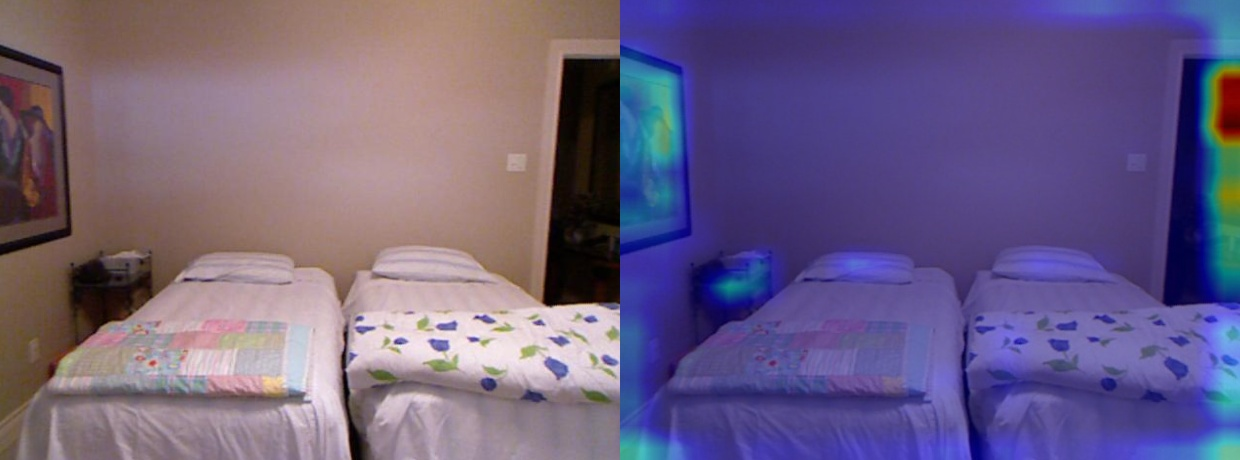

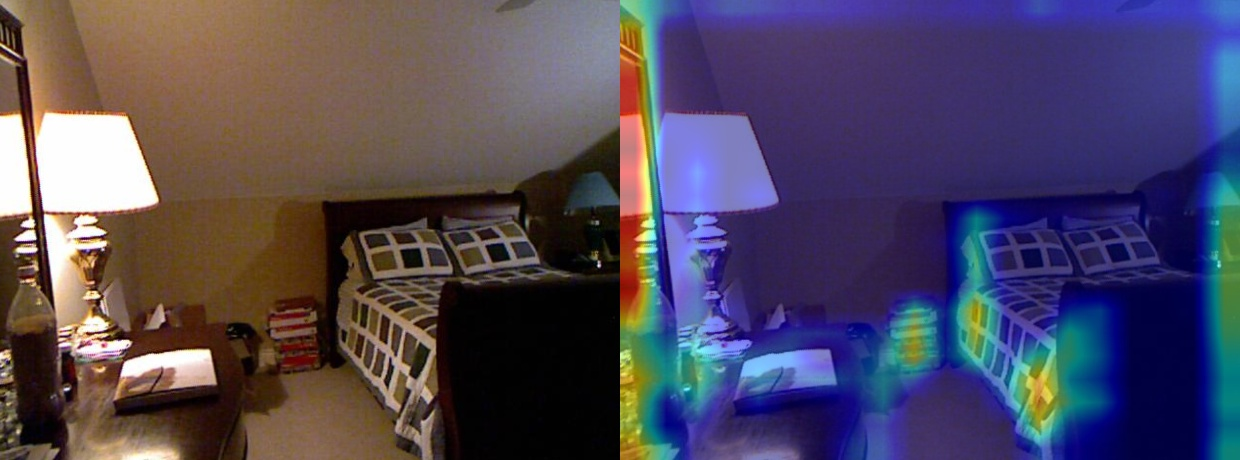

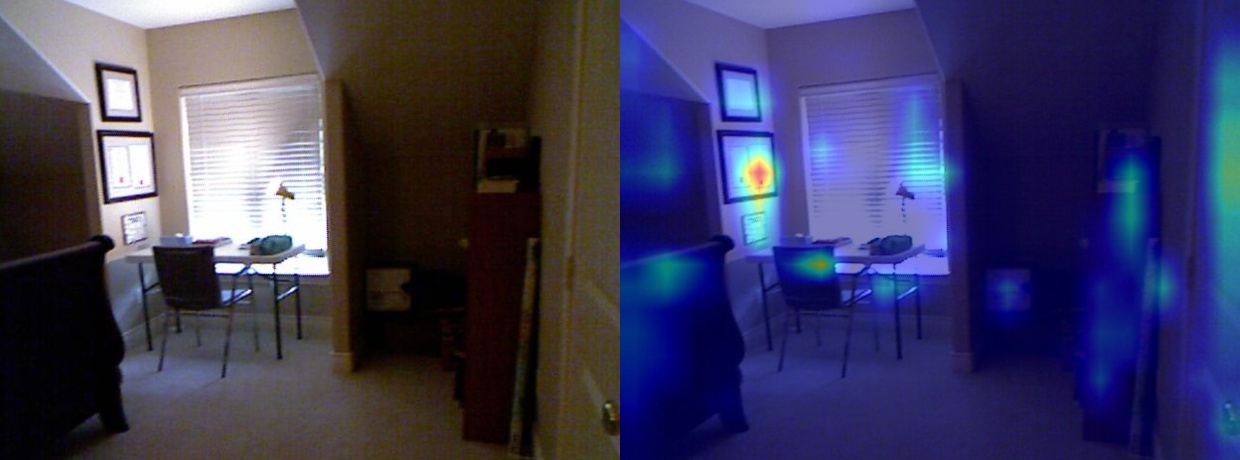

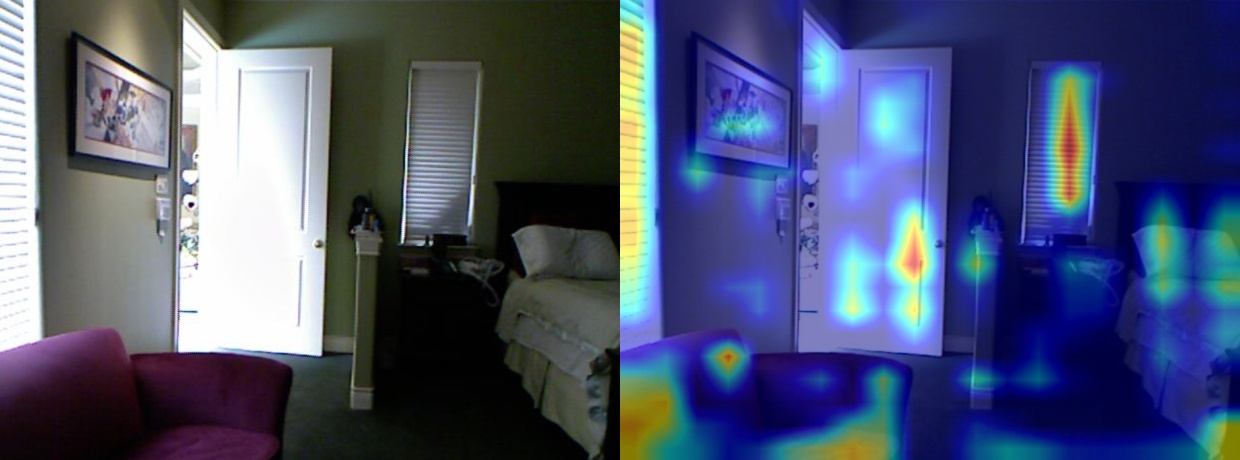

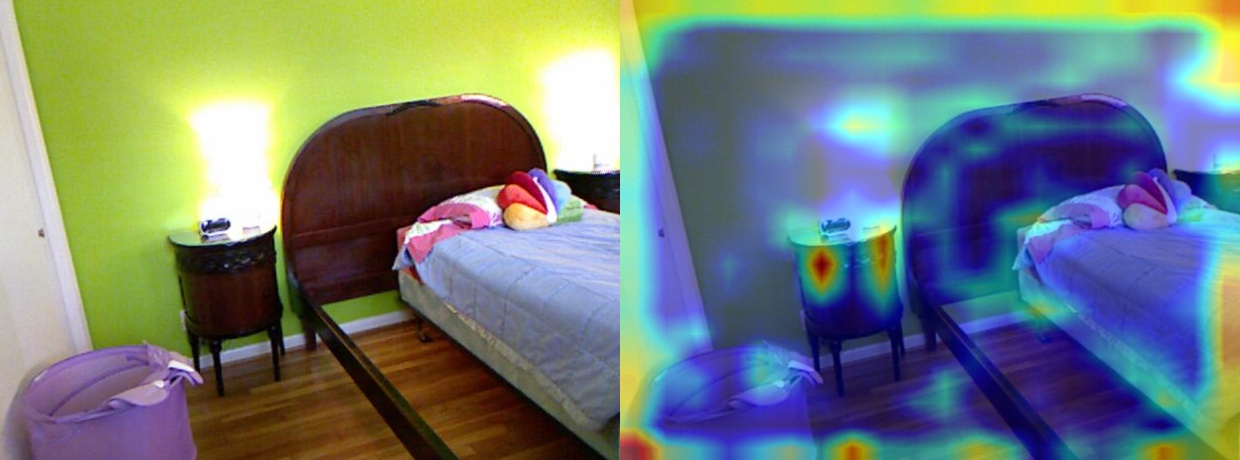

In [14]:
import os, glob, cv2, torch
import numpy as np
from ultralytics import YOLO
from torch.nn.functional import interpolate
from IPython.display import display, Image as IPyImage

WEIGHTS  = "/kaggle/working/runs/detect/train/weights/best.pt"
TEST_DIR = "/kaggle/input/indoor-object-detection/test/images"
OUT_DIR  = "/kaggle/working/gradcam_indoor"
IMGSZ    = 640

os.makedirs(OUT_DIR, exist_ok=True)

# Load model
yolo = YOLO(WEIGHTS)
net  = yolo.model
net.train(False)
for p in net.parameters():
    p.requires_grad_(True)

# Pick a target layer (last Conv/C2f before Detect)
modules = list(net.model)
def pick_target_layer(mods):
    for m in reversed(mods[:-1]):
        if "c2f" in m.__class__.__name__.lower() or "conv" in m.__class__.__name__.lower():
            return m
    return mods[-2]
target_layer = pick_target_layer(modules)
print("Target layer:", target_layer.__class__.__name__)

# Hooks
feats, grads = {}, {}
def fwd_hook(m, i, o): feats['v'] = o
def bwd_hook(m, gi, go): grads['v'] = go[0]
h1 = target_layer.register_forward_hook(fwd_hook)
h2 = target_layer.register_full_backward_hook(bwd_hook)

# Preprocess
def load_preprocess(path, size=IMGSZ):
    bgr = cv2.imread(path); assert bgr is not None, path
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb_resized = cv2.resize(rgb, (size, size))
    x = torch.from_numpy(rgb_resized).float().permute(2,0,1) / 255.0
    return bgr, rgb, x.unsqueeze(0)

device = next(net.parameters()).device

def gradcam_on_image(img_path):
    bgr, rgb, x = load_preprocess(img_path, IMGSZ)
    x = x.to(device)

    net.zero_grad(set_to_none=True)
    feats.clear(); grads.clear()

    out = net(x)
    if isinstance(out, (list, tuple)): out = out[0]
    if isinstance(out, dict): out = out.get('pred', list(out.values())[0])

    cls_logits = out[..., 4:] if out.shape[-1] > 4 else out
    score = torch.sigmoid(cls_logits).max(dim=-1)[0].sum()
    score.backward()

    A = feats['v']
    G = grads['v']
    if A.dim()==3: A = A.unsqueeze(0)
    if G.dim()==3: G = G.unsqueeze(0)

    w = G.mean(dim=(2,3), keepdim=True)
    cam = torch.relu((w * A).sum(dim=1, keepdim=True))

    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    # 🔹 FIX: detach before numpy()
    cam_up = interpolate(cam, size=(rgb.shape[0], rgb.shape[1]), mode='bilinear',
                         align_corners=False)[0,0].detach().cpu().numpy()

    heat = (cam_up * 255).astype(np.uint8)
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
    overlay = (0.5 * cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR) + 0.5 * heat).astype(np.uint8)

    side = np.hstack([cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR), overlay])
    out_path = os.path.join(OUT_DIR, os.path.basename(img_path).rsplit(".",1)[0] + "_cam.jpg")
    cv2.imwrite(out_path, side)
    return out_path

# Run on a few test images
paths = sorted(glob.glob(os.path.join(TEST_DIR, "*.*")))[:8]
outs = [gradcam_on_image(p) for p in paths]

h1.remove(); h2.remove()

for p in outs:
    display(IPyImage(filename=p, width=900))


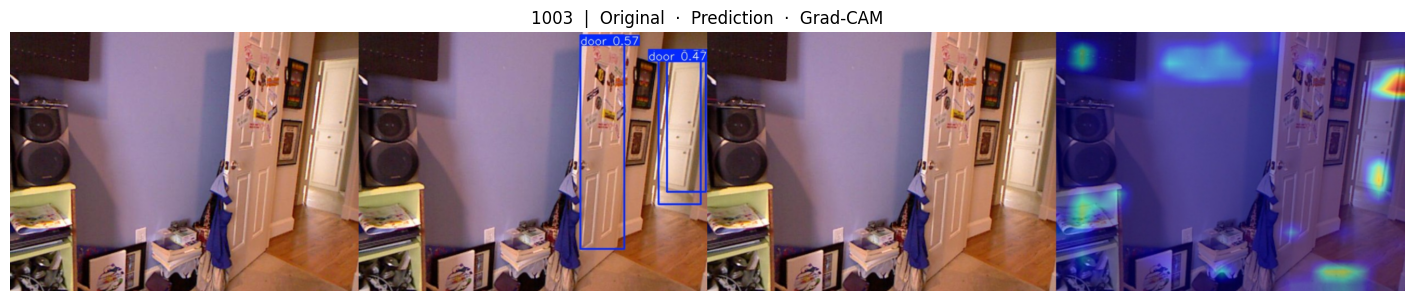

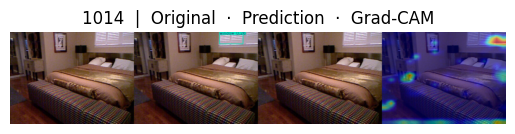

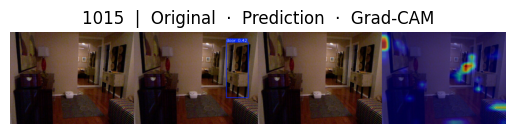

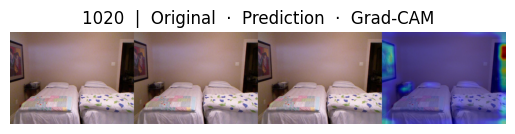

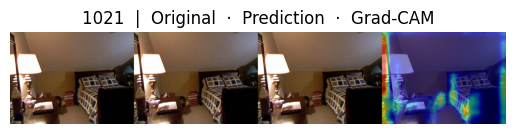

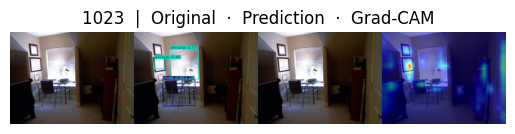

Displayed 6 triplet(s). From:
- test: /kaggle/input/indoor-object-detection/test/images
- predict: /kaggle/working/runs/detect/predict2
- cam: /kaggle/working/gradcam_indoor


In [22]:
import os, glob, cv2, numpy as np
import matplotlib.pyplot as plt

# === CONFIG ===
TEST_DIR = "/kaggle/input/indoor-object-detection/test/images"
PRED_ROOT = "/kaggle/working/runs/detect"            # where Ultralytics saves predict*
CAM_DIR   = "/kaggle/working/gradcam_indoor"         # where your _cam.jpg were saved
MAX_SHOW  = 6                                        # how many triplets to display
IMG_H     = 480                                      # target height for stacking (keeps aspect)

# ------------- helpers -------------
def latest_predict_dir(root=PRED_ROOT):
    preds = sorted(glob.glob(os.path.join(root, "predict*")), key=os.path.getmtime)
    return preds[-1] if preds else None

def read_rgb(path):
    if not path or not os.path.exists(path): return None
    im = cv2.imread(path)
    if im is None: return None
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def resize_to_h(img, h):
    if img is None: return None
    return cv2.resize(img, (int(img.shape[1] * h / img.shape[0]), h), interpolation=cv2.INTER_LINEAR)

def stack_triplet(orig, pred, cam, h=IMG_H):
    # resize all to same height
    orig = resize_to_h(orig, h)
    pred = resize_to_h(pred, h)
    cam  = resize_to_h(cam,  h)
    # replace any missing panel with a gray placeholder
    w = orig.shape[1] if orig is not None else (pred.shape[1] if pred is not None else (cam.shape[1] if cam is not None else 640))
    ph = np.full((h, w, 3), 180, dtype=np.uint8)
    orig = orig if orig is not None else ph
    pred = pred if pred is not None else ph
    cam  = cam  if cam  is not None else ph
    return np.hstack([orig, pred, cam])

# find latest predict folder
pred_dir = latest_predict_dir()
if pred_dir is None:
    raise SystemExit("No predict folder found. Run YOLO predict first with save=True.")

# build maps for quick lookup
pred_candidates = {os.path.splitext(os.path.basename(p))[0]: p
                   for p in glob.glob(os.path.join(pred_dir, "*.*"))}

cam_candidates  = {}
for p in glob.glob(os.path.join(CAM_DIR, "*.*")):
    stem = os.path.basename(p)
    # expects XYZ_cam.jpg → base name without _cam
    if "_cam" in stem:
        cam_candidates[stem.replace("_cam", "").rsplit(".", 1)[0]] = p

# iterate test images and display triplets
test_images = sorted(glob.glob(os.path.join(TEST_DIR, "*.*")))
shown = 0
plt.figure(figsize=(18, 6 * min(MAX_SHOW, 3)))

for idx, tpath in enumerate(test_images):
    base = os.path.splitext(os.path.basename(tpath))[0]
    # prediction render: Ultralytics usually keeps the original stem
    # but may change extension; try direct stem match
    pred_path = None
    for ext in (".jpg", ".png", ".jpeg", ".JPG", ".PNG"):
        cand = pred_candidates.get(base) or pred_candidates.get(base + ext.replace(".", "_"))
        if cand:
            pred_path = cand
            break
    # fallback: scan by startswith base
    if not pred_path:
        for k, v in pred_candidates.items():
            if k.startswith(base):
                pred_path = v; break

    cam_path = cam_candidates.get(base)

    orig = read_rgb(tpath)
    pred = read_rgb(pred_path)
    cam  = read_rgb(cam_path)

    panel = stack_triplet(orig, pred, cam, h=IMG_H)
    plt.subplot(min(MAX_SHOW, 3), 1 if MAX_SHOW <= 3 else 1, 1)  # keep single big panel per loop when showing interactively
    plt.imshow(panel); plt.axis("off")
    plt.title(f"{base}  |  Original  ·  Prediction  ·  Grad-CAM")
    plt.show()

    shown += 1
    if shown >= MAX_SHOW:
        break

print(f"Displayed {shown} triplet(s). From:\n- test: {TEST_DIR}\n- predict: {pred_dir}\n- cam: {CAM_DIR}")
